In [20]:
import os

import time
import progressbar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline
plt.style.use('seaborn')

In [2]:
BATCH_SIZE = 32
NUM_CLASSES = 3
LEVEL = "phylum"
EPOCH = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    return X, y

In [4]:
data_base_path = "../data/hierarchy/"+LEVEL

train_sequences, train_labels = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
val_sequences, val_labels = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
test_sequences, test_labels = read_data_from_csv(os.path.join(data_base_path, "test.csv"))

In [5]:
a = list(map(lambda x: len(x), train_sequences))

print("DNA Sequence Length Statistics:")
print("Max:", np.max(a))
print("Min:", np.min(a))
print("Mean:", np.ceil(np.mean(a)))
print("Median:", np.ceil(np.median(a)))
print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))

DNA Sequence Length Statistics:
Max: 1370
Min: 1270
Mean: 1347.0
Median: 1348.0
Sqrt of Max: 38.0


In [6]:
IMAGE_WIDTH = IMAGE_HEIGHT = 38  # 1444 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

In [7]:
base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [8]:
train_data = seqeunces_to_image(train_sequences)
val_data = seqeunces_to_image(val_sequences)
test_data = seqeunces_to_image(test_sequences)

In [9]:
base_pair_colors = {
    (1, 0, 0, 0): [183, 28, 28],  # red
    (0, 1, 0, 0): [174, 234, 0],  # green
    (0, 0, 1, 0): [0, 145, 234],  # blue
    (0, 0, 0, 1): [255, 111, 0],  # orange
    (0, 0, 0, 0): [33, 33, 33]   # black
}

def viz_dna_image(dna_image):
    dna_rgb_image = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    for i, row in enumerate(dna_image):
        for j, col in enumerate(row):
            dna_rgb_image[i][j] = base_pair_colors[tuple(col)]
    plt.imshow(dna_rgb_image/255.0)

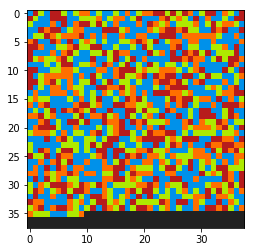

In [10]:
viz_dna_image(train_data[100])

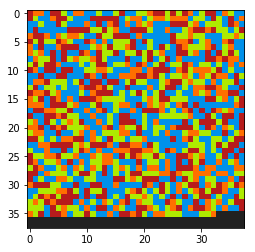

In [11]:
viz_dna_image(train_data[1000])

In [12]:
def create_pytorch_datasets(data, labels):
    tensor_x = torch.stack([torch.Tensor(np.swapaxes(i, 0, 2)) for i in data]) # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in labels]).long().view(-1)

    dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloader = utils.DataLoader(dataset, batch_size=BATCH_SIZE) # create your dataloader
    
    return dataloader

In [13]:
train_dataloader = create_pytorch_datasets(train_data, train_labels)
val_dataloader = create_pytorch_datasets(val_data, val_labels)
test_dataloader = create_pytorch_datasets(test_data, test_labels)

In [14]:
class SimpleCNN(nn.Module):

    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=10, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1)
        self.fc1 = nn.Linear(81*64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = F.log_softmax(self.fc1(x), dim=1)
        return(x)

In [15]:
def cnn_train_model(model, train_loader, test_loader, optimizer, scheduler, EPOCH, config):
    model = model.to(DEVICE)

    if DEVICE == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    t0 = time.perf_counter()

    loss_train = np.zeros((EPOCH,))
    loss_test = np.zeros((EPOCH,))
    acc_test = np.zeros((EPOCH,))
    acc_train = np.zeros((EPOCH,))
    time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(min_value=0, max_value=EPOCH-1)
    for epoch in range(EPOCH):
        bar.update(epoch)
        scheduler.step()

        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').item()

        acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        for step, (x, y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

        loss_test[epoch] = test_loss/len(test_loader.dataset)
        acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        time_test[epoch] = time.perf_counter() - t0

    return [acc_train, acc_test, loss_train, loss_test, config]

In [16]:
def cnn_train_test(model, train_loader, test_loader, config={}):
    # set params
    if config:
        print("Experiment:", str(config))
        learning_rate = config["lr"]
        weight_decay = config["weight_decay"]

    if config:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                    momentum=.9, weight_decay=weight_decay)
    else:
        # used Adadelta, as it wokrs well without any magic numbers
        optimizer = torch.optim.Adadelta(model.parameters())

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=EPOCH/3, gamma=.1)

    return cnn_train_model(model, train_loader, test_loader, optimizer, scheduler, EPOCH, config)

In [17]:
def plot(acc_train, acc_test, loss_train, loss_test):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label='Acc. Train')
    plt.plot(acc_test, label='Acc. Test')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(loss_train, label='Loss Train')
    plt.plot(loss_test, label='Loss Test')
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    plt.clf()

In [18]:
logs = cnn_train_test(SimpleCNN(NUM_CLASSES), train_dataloader, val_dataloader)

100% (9 of 9) |##########################| Elapsed Time: 0:04:29 ETA:  00:00:00

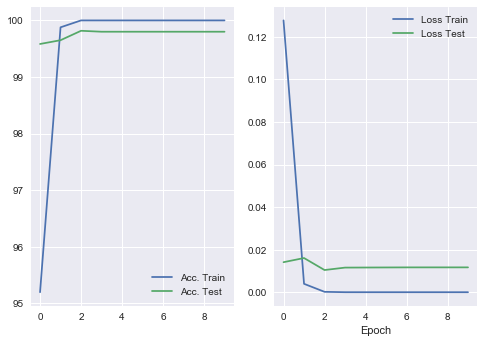

<Figure size 576x396 with 0 Axes>

In [21]:
plot(*logs[:-1])